In [1]:
@everywhere using Distributions
@everywhere using Base.Test
@everywhere using StatsBase
@everywhere using BenchmarkTools
using MCMCDiagnostics
cd("../Source/")
@everywhere include("functions_msc.jl")
@everywhere include("types.jl")
@everywhere include("functions_neighbors.jl")
@everywhere include("functions_types.jl")
@everywhere include("functions_symmetric_energy.jl")
@everywhere include("functions_mc.jl")
@everywhere include("functions_thermalization.jl")
@everywhere include("functions_observables.jl")
include("functions_plots_and_files.jl")
cd("../Notebooks/")
using Plots
pyplot()

Plots.PyPlotBackend()

In [12]:
THERM_FRAC = 1/10
DT_MAX = 10000

@everywhere const two_pi = 2π

# We run a simulation with the parameters
g = 0.03    # Gauge coupling
ν = 0.3    # Anisotropy

# Other parameters
L = 10# System length
L₃ = 10
T = 0.6 #0.11039   # Temperature
γ = 1.0    # Order parameter amplitud
κ₅ = 1.0
f = 1.0/L
println("f set to $(f)")
β = 1/T
println("β set to $(β)")

# Create system
syst = SystConstants(L, L₃, γ, 1/g^2, ν, κ₅, f, β)
sim = Controls(π - π/12, 0.7, 6.0)

# Measurement parameters
M = 300    # Number of measurements
Δt = 400  # Interval between measurements (MCS)
# Construct k-matrix where the horizontal axis contains kx ∈ [-π, π), while
# the vertical axis contain ky ∈ [-π, π) at the second component
k_matrix = [[2π/L*(x-1-L/2), 2π/L*(L/2-y)] for y=1:L, x=1:L];

f set to 0.1
β set to 1.6666666666666667


In [4]:
ψ = State(2, syst);

# Benchmarking changing use of rng objects

In [3]:
function proposeLocalUpdate2(ϕ::LatticeSite, sim::Controls)
    UMAX::Int64 = 4
    u⁺ = 1.0#mod(ϕ.u⁺ + rand(Uniform(-sim.umax,sim.umax)), UMAX) # This does not allow u⁺ = UMAX, is this a problem?
	u⁻ = 0.0#mod(ϕ.u⁻ + rand(Uniform(-sim.umax,sim.umax)), UMAX)
    # Construct new configuration at lattice site.
    #return LatticeSite([ϕ.A[1]+rand(Uniform(-sim.Amax,sim.Amax)), ϕ.A[2]+rand(Uniform(-sim.Amax,sim.Amax)),
    #                    ϕ.A[3]+rand(Uniform(-sim.Amax,sim.Amax))],
    #    mod(ϕ.θ⁺ + rand(Uniform(-sim.θmax,sim.θmax)), 2π), mod(ϕ.θ⁻ + rand(Uniform(-sim.θmax,sim.θmax)), 2π), 
    #    u⁺, u⁻)
#    return LatticeSite([ϕ.A[1]+rand(Uniform(-sim.Amax,sim.Amax)), ϕ.A[2]+rand(Uniform(-sim.Amax,sim.Amax)),
#                        ϕ.A[3]+rand(Uniform(-sim.Amax,sim.Amax))],
#        mod(ϕ.θ⁺ + rand(Uniform(-sim.θmax,sim.θmax)), 2π), mod(ϕ.θ⁻ + rand(Uniform(-sim.θmax,sim.θmax)), 2π), 
#        u⁺, u⁻)
    return LatticeSite([0, 0, 0],
        mod(ϕ.θ⁺ + rand(sim.θ_rng), 2π), mod(ϕ.θ⁻ + rand(sim.θ_rng), 2π), 
        u⁺, u⁻)
end
function proposeLocalUpdate1(ϕ::LatticeSite, sim::Controls)
    UMAX::Int64 = 4
    u⁺ = 1.0#mod(ϕ.u⁺ + rand(Uniform(-sim.umax,sim.umax)), UMAX) # This does not allow u⁺ = UMAX, is this a problem?
	u⁻ = 0.0#mod(ϕ.u⁻ + rand(Uniform(-sim.umax,sim.umax)), UMAX)
    # Construct new configuration at lattice site.
    #return LatticeSite([ϕ.A[1]+rand(Uniform(-sim.Amax,sim.Amax)), ϕ.A[2]+rand(Uniform(-sim.Amax,sim.Amax)),
    #                    ϕ.A[3]+rand(Uniform(-sim.Amax,sim.Amax))],
    #    mod(ϕ.θ⁺ + rand(Uniform(-sim.θmax,sim.θmax)), 2π), mod(ϕ.θ⁻ + rand(Uniform(-sim.θmax,sim.θmax)), 2π), 
    #    u⁺, u⁻)
#    return LatticeSite([ϕ.A[1]+rand(Uniform(-sim.Amax,sim.Amax)), ϕ.A[2]+rand(Uniform(-sim.Amax,sim.Amax)),
#                        ϕ.A[3]+rand(Uniform(-sim.Amax,sim.Amax))],
#        mod(ϕ.θ⁺ + rand(Uniform(-sim.θmax,sim.θmax)), 2π), mod(ϕ.θ⁻ + rand(Uniform(-sim.θmax,sim.θmax)), 2π), 
#        u⁺, u⁻)
    return LatticeSite([0, 0, 0],
        mod(ϕ.θ⁺ + rand(Uniform(-sim.θmax, sim.θmax)), 2π), mod(ϕ.θ⁻ + rand(Uniform(-sim.θmax, sim.θmax)), 2π), 
        u⁺, u⁻)
end

proposeLocalUpdate1 (generic function with 1 method)

In [3]:
rand(Uniform(-1,1))

-0.8123940293992891

In [4]:
typeof(Uniform(-1,1))

Distributions.Uniform{Float64}

In [22]:
@benchmark mod2pi(3π)

BenchmarkTools.Trial: 
  memory estimate:  96 bytes
  allocs estimate:  1
  --------------
  minimum time:     91.742 ns (0.00% GC)
  median time:      132.923 ns (0.00% GC)
  mean time:        156.785 ns (15.35% GC)
  maximum time:     8.740 μs (97.49% GC)
  --------------
  samples:          10000
  evals/sample:     911

In [23]:
@benchmark mod(3π, 2π)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     18.357 ns (0.00% GC)
  median time:      26.035 ns (0.00% GC)
  mean time:        31.051 ns (0.00% GC)
  maximum time:     4.072 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     995

In [7]:
@benchmark rand(Uniform(-sim.θmax,sim.θmax))

BenchmarkTools.Trial: 
  memory estimate:  96 bytes
  allocs estimate:  5
  --------------
  minimum time:     289.980 ns (0.00% GC)
  median time:      419.169 ns (0.00% GC)
  mean time:        445.670 ns (5.30% GC)
  maximum time:     37.099 μs (96.77% GC)
  --------------
  samples:          10000
  evals/sample:     201

In [8]:
@benchmark rand(sim.θ_rng)

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  2
  --------------
  minimum time:     80.576 ns (0.00% GC)
  median time:      116.301 ns (0.00% GC)
  mean time:        126.045 ns (7.09% GC)
  maximum time:     6.356 μs (96.04% GC)
  --------------
  samples:          10000
  evals/sample:     923

In [9]:
@benchmark proposeLocalUpdate1(ψ.lattice[1,1,1], sim)

BenchmarkTools.Trial: 
  memory estimate:  272 bytes
  allocs estimate:  3
  --------------
  minimum time:     243.781 ns (0.00% GC)
  median time:      344.408 ns (0.00% GC)
  mean time:        400.898 ns (12.75% GC)
  maximum time:     22.026 μs (95.94% GC)
  --------------
  samples:          10000
  evals/sample:     228

In [10]:
@benchmark proposeLocalUpdate2(ψ.lattice[1,1,1], sim)

BenchmarkTools.Trial: 
  memory estimate:  272 bytes
  allocs estimate:  3
  --------------
  minimum time:     244.219 ns (0.00% GC)
  median time:      355.777 ns (0.00% GC)
  mean time:        415.156 ns (12.18% GC)
  maximum time:     28.966 μs (96.17% GC)
  --------------
  samples:          10000
  evals/sample:     215

In [17]:
@time proposeLocalUpdate1(ψ.lattice[1,1,1], sim);

  0.000011 seconds (7 allocations: 432 bytes)


In [18]:
@time proposeLocalUpdate2(ψ.lattice[1,1,1], sim);

  0.000012 seconds (7 allocations: 432 bytes)


# Code for saving states

In [36]:
M = 8
ψ_list = [ψ for i = 1:M];

In [101]:
digits(3, 10, 10)

10-element Array{Int64,1}:
 3
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [4]:
# -------------------------------------------------------------------------------------------------
# Saves the state to file with specified filename. If mode is set to "a" then the state is appended
# to the file.
function save(ψ::State, filename::AbstractString, mode::AbstractString="w")
    if mode != "w" && mode != "a"
        println("$(mode) is not a valid file-opening option.")
        return 0
    end
    println("Saving state to file $(filename)")
    L = ψ.consts.L
    L₃ = ψ.consts.L₃
    open(filename, mode) do f
        # Write line indicating start of state
        write(f, "state start\n")
        # Writing system constants on top of the file
        write(f, "$(ψ.consts.L)\n")
        write(f, "$(ψ.consts.L₃)\n")
        write(f, "$(ψ.consts.γ)\n")
        write(f, "$(ψ.consts.g⁻²)\n")
        write(f, "$(ψ.consts.ν)\n")
        write(f, "$(ψ.consts.κ₅)\n")
        write(f, "$(ψ.consts.f)\n")
        write(f, "$(ψ.consts.β)\n")
        # Then starting writing the state lattice
        for z=1:L₃, x=1:L, y=1:L
            ϕ = ψ.lattice[y,x,z]
            write(f, "$(ϕ.A[1]):$(ϕ.A[2]):$(ϕ.A[3]):$(ϕ.θ⁺):$(ϕ.θ⁻):$(ϕ.u⁺):$(ϕ.u⁻)\n")
        end
        write(f, "end\n")
    end
    return 1
end



save (generic function with 4 methods)

In [5]:
function save(ψ_list::Array{State, 1}, filename::AbstractString="state_list.data")
    MAX_NUM_DIGITS = 10
    open(filename, "w") do f
        write(f, "state array\n")
        M = digits(length(ψ_list), 10, MAX_NUM_DIGITS)
        for i = 1:MAX_NUM_DIGITS
            write(f, "$(M[MAX_NUM_DIGITS-i+1])")
        end
        write(f, "\n")
        write(f, "$(ψ_list[1].consts.L):$(ψ_list[1].consts.L₃):$(ψ_list[1].consts.γ):$(ψ_list[1].consts.g⁻²):")
        write(f, "$(ψ_list[1].consts.ν):$(ψ_list[1].consts.κ₅):$(ψ_list[1].consts.f):$(ψ_list[1].consts.β)\n")
        for ψ in ψ_list
            write(f, "state start\n")
            for z=1:L₃, h=1:L, v=1:L
                ϕ = ψ.lattice[v,h,z]
                write(f, "$(ϕ.A[1]):$(ϕ.A[2]):$(ϕ.A[3]):$(ϕ.θ⁺):$(ϕ.θ⁻):$(ϕ.u⁺):$(ϕ.u⁻)\n")
            end
        end
    end
    return 1
end

save (generic function with 4 methods)

In [6]:
function addToList(ψ::State, filename::AbstractString)
    MAX_NUM_DIGITS = 10 # Has to be the same as number used in save(::Array{State,1}, ::AbstractString)
    M₀ = 0
    # Get length of existing list and check that constants are the same as state.
    open(filename, "r") do file
        line = readline(file)
        if line != "state array"
            println("ERROR: Start of file is $(line)")
            throw(Domainerror())
        end
        M₀ = parse(Int64, readline(file))
        M₀ > 0 || throw(error("ERROR: Number of states in list is set to $(M₀)"))
        c_values = split(readline(file), ":")
        L = parse(Int64, c_values[1])
        L > 0 || throw(error("ERROR: States L is $(L)"))
        L₃ = parse(Int64, c_values[2])
        L₃ > 0 || throw(error("ERROR: States L₃ is $(L₃)"))
        γ = parse(Float64, c_values[3])
        g⁻² = parse(Float64, c_values[4])
        ν = parse(Float64, c_values[5])
        κ₅ = parse(Float64, c_values[6])
        f = parse(Float64, c_values[7])
        β = parse(Float64, c_values[8])
        if !(ψ.consts.L == L && ψ.consts.L₃ == L₃ && ψ.consts.γ == γ && ψ.consts.g⁻² == g⁻² && ψ.consts.ν == ν
                && ψ.consts.κ₅ == κ₅ && ψ.consts.f == f && ψ.consts.β == β)
            throw(error("ERROR: Input-state's constants do not match stored constants.
\tL\tL₃\tγ\tg⁻²\tν\tκ₅\tf\tβ
stored:\t$(L)\t$(L₃)\t$(γ)\t$(g⁻²)\t$(ν)\t$(κ₅)\t$(f)\t$(β)
input:\t$(ψ.consts.L)\t$(ψ.consts.L₃)\t$(ψ.consts.γ)\t$(ψ.consts.g⁻²)\t$(ψ.consts.ν)\t$(ψ.consts.κ₅)\t$(ψ.consts.f)\t$(ψ.consts.β)"))
        end
    end
    # Save lattice to new state at the end
    open(filename, "a") do file
        write(file, "state start\n")
        for z=1:L₃, h=1:L, v=1:L
            ϕ = ψ.lattice[v,h,z]
            write(file, "$(ϕ.A[1]):$(ϕ.A[2]):$(ϕ.A[3]):$(ϕ.θ⁺):$(ϕ.θ⁻):$(ϕ.u⁺):$(ϕ.u⁻)\n")
        end
    end
    # Update length of list by 1.
    open(filename, "r+") do file
        line = readline(file)
        M_list = digits(M₀+1, 10, MAX_NUM_DIGITS)
        for i = 1:MAX_NUM_DIGITS
            write(file, "$(M_list[MAX_NUM_DIGITS-i+1])")
        end
        write(file, "\n")
    end
    return 1
end

addToList (generic function with 1 method)

In [105]:
save(ψ_list, "state_list.data")

1

In [107]:

for i = 1:6
    addToList(State(2, syst), "state_list.data")
end


Read M₀ = 4
Read L = 64
Read M₀ = 5
Read L = 64
Read M₀ = 6
Read L = 64
Read M₀ = 7
Read L = 64
Read M₀ = 8
Read L = 64
Read M₀ = 9
Read L = 64


In [106]:
addToList(State(2,syst), "state_list.data")

Read M₀ = 3
Read L = 64


1

In [68]:
ψ_l = loadStates("state_list.data");

In [92]:
open("state_list.data", "r+") do file
    line = readline(file)
    write(file, "eselet slurer på halen\n")
end

24

In [7]:
function loadStates(filename::AbstractString)
    open(filename, "r") do file
        line = readline(file)
        if line != "state array"
            throw(DomainError())
        end
        M = parse(Int64, readline(file))
        M > 0 || throw(DomainError())
        ψ_l = Array{State, 1}(M)
        c_values = split(readline(file), ":")
        L = parse(Int64, c_values[1])
        L > 0 || throw(DomainError())
        L₃ = parse(Int64, c_values[2])
        L₃ > 0 || throw(DomainError())
        γ = parse(Float64, c_values[3])
        g⁻² = parse(Float64, c_values[4])
        ν = parse(Float64, c_values[5])
        κ₅ = parse(Float64, c_values[6])
        f = parse(Float64, c_values[7])
        β = parse(Float64, c_values[8])
        for i = 1:M
            line = readline(file)
            if line != "state start"
                throw(DomainError())
            end
            syst = SystConstants(L,L₃,γ,g⁻²,ν,κ₅,f,β)
            lattice = Array{LatticeSite, 3}(L,L,L₃)
            for z_pos = 1:L₃, h_pos = 1:L, v_pos = 1:L
                ϕ_values = split(readline(file), ":")
                A₁ = parse(Float64, ϕ_values[1])
                A₂ = parse(Float64, ϕ_values[2])
                A₃ = parse(Float64, ϕ_values[3])
                θ⁺ = parse(Float64, ϕ_values[4])
                θ⁻ = parse(Float64, ϕ_values[5])
                u⁺ = parse(Float64, ϕ_values[6])
                u⁻ = parse(Float64, ϕ_values[7])
                lattice[v_pos,h_pos,z_pos] = LatticeSite([A₁, A₂, A₃], θ⁺, θ⁻, u⁺, u⁻)
            end

            nbl = latticeNeighbors(lattice,L,L₃)
            nnbl = latticeNextNeighbors(lattice,L,L₃)
            nnnbl = latticeNNNeighbors(lattice,L,L₃)

            ψ_l[i] = State(lattice, syst, nbl, nnbl, nnnbl)
        end
        return ψ_l
    end
end

loadStates (generic function with 1 method)

# Make thermal averages use this functionality

In [8]:
@everywhere function addToChannel(r_c::RemoteChannel{Channel{Int64}})
    put!(r_c, floor(Int64, 10*rand()))
    return 1
end

In [30]:
c = Channel{Int64}(5)
r_c = RemoteChannel(()->Channel{Int64}(5))
future = @spawn addToChannel(r_c)
sleep(1)
if isready(r_c)
    println("First!")
    println(take!(r_c))
end
println(r_c)
println(fetch(future))
if isready(r_c)
    println("Second!")
    println(take!(r_c))
end

RemoteChannel{Channel{Int64}}(1, 1, 16)


LoadError: [91mOn worker 2:
[91mUndefVarError: addToChannel not defined[39m
#192 at ./distributed/macros.jl:20
#103 at ./distributed/process_messages.jl:264 [inlined]
run_work_thunk at ./distributed/process_messages.jl:56
run_work_thunk at ./distributed/process_messages.jl:65 [inlined]
#96 at ./event.jl:73[39m

In [2]:
# --------------------------------------------------------------------------------------------------
# Complimentary function to measurementSeries! Makes M measurements of the state and writes these
# state-measurements to the remote channel. Each measurement is done with Δt MCS between them.
@everywhere function measureStates!(ψ::State, sim::Controls, M::Int64, Δt::Int64, r_chan::RemoteChannel{Channel{State}})
#    u⁺_list = Array{Float64, 1}(M); u⁻_list = Array{Float64, 1}(M)
#    u⁺_list[1], u⁻_list[1] = meanAmplitudes(ψ)
    put!(r_chan, ψ) # First measurement

    for m = 2:M
        nMCS(ψ, sim, Δt)
        put!(r_chan, ψ)
    end
    
    return 1
end

In [3]:
# --------------------------------------------------------------------------------------------------
# Complimentary function to measurementSeries! Makes M measurements of the state and writes these
# state-measurements to the remote channel. Each measurement is done with Δt MCS between them.
@everywhere function measureStates2!(ψ::State, sim::Controls, M::Int64, Δt::Int64)
#    u⁺_list = Array{Float64, 1}(M); u⁻_list = Array{Float64, 1}(M)
#    u⁺_list[1], u⁻_list[1] = meanAmplitudes(ψ)
    ψ_res = Array{State,1}(M)
    ψ_res[1] = ψ # First measurement

    for m = 2:M
        nMCS(ψ, sim, Δt)
        ψ_res[m] = ψ
    end
    
    return ψ_res
end

In [4]:
function addChannelToDiskList(r_chan::RemoteChannel{Channel{State}}, filename::AbstractString)
    while isready(r_chan)
        addToList(take!(r_chan), filename)
    end
    return 1
end

addChannelToDiskList (generic function with 1 method)

In [5]:
# --------------------------------------------------------------------------------------------------
# Complimentary function to measurementSeries! Makes M measurements of the state and writes these
# state-measurements to the remote channel. Each measurement is done with Δt MCS between them.
function measureStatesMaster!(ψ::State, sim::Controls, M::Int64, Δt::Int64, r_chan::RemoteChannel{Channel{State}},
        filename::AbstractString)
    
    PROG_NUM = 10
#    u⁺_list = Array{Float64, 1}(M); u⁻_list = Array{Float64, 1}(M)
#    u⁺_list[1], u⁻_list[1] = meanAmplitudes(ψ)
    save([ψ], filename) # First measurement starts a state-list on disk.
    
    prog_int = max(1,floor(Int64, M/PROG_NUM))
    # Preform remaining (M-1) measurements
    for m = 2:M
        nMCS(ψ, sim, Δt)                       # Wait Δt MCS
        addToList(ψ, filename)                 # Write state to disk
        #if isready(r_chan)
        #    addChannelToDiskList(r_chan, filename)   # Update disk with possible state measurements from workers.
        #end
        # Print measurement progress
        if m % prog_int == 0
            println("Measurement progress: $(Int(round(m/M*100,0)))%")
            flush(STDOUT)
        end
    end
    
    return 1
end

measureStatesMaster! (generic function with 1 method)

In [6]:
# --------------------------------------------------------------------------------------------------
# Complimentary function to measurementSeries! Makes M measurements of the state and writes these
# state-measurements to the remote channel. Each measurement is done with Δt MCS between them.
function measureStatesMaster2!(ψ::State, sim::Controls, M::Int64, Δt::Int64,
        filename::AbstractString)
    
    PROG_NUM = 10
    ψ_res = Array{State, 1}(M)
#    u⁺_list = Array{Float64, 1}(M); u⁻_list = Array{Float64, 1}(M)
#    u⁺_list[1], u⁻_list[1] = meanAmplitudes(ψ)
    ψ_res[1] = ψ # First measurement
    
    prog_int = max(1,floor(Int64, M/PROG_NUM))
    # Preform remaining (M-1) measurements
    for m = 2:M
        nMCS(ψ, sim, Δt)                       # Wait Δt MCS
        ψ_res[m] = ψ
        
        # Print measurement progress
        if m % prog_int == 0
            println("Measurement progress: $(Int(round(m/M*100,0)))%")
            flush(STDOUT)
        end
    end
    
    return ψ_res
end

measureStatesMaster2! (generic function with 1 method)

In [7]:
function writeChannel(r_chan::RemoteChannel{Channel{State}}, filename::AbstractString)
    while true
        ψ = take!(r_chan)
        addToList(ψ, filename)
    end
end

# --------------------------------------------------------------------------------------------------
# Given np+1 uncorrelated states in ψ_list we use these to make M measurements of the states by splitting
# the M measurements on the np workers as well as the master process. The measured states are continuously
# stored in an file which can later be read to produce a measurement array of lattices.
function measurementSeries!(ψ_list::Array{State,1}, sim::Controls, M::Int64, Δt::Int64; filename="state_list.data")
    syst = ψ_list[1].consts
    L = syst.L
    
    M = M-1 # We use one of the states in ψ_list as first measurement to initialize file.
    # Setup storage channel for parallel processes
    ψ_chan = RemoteChannel(()->Channel{State}(M))
    
     # Splitting the problem into np sub-problems.
    np = nprocs()-1
    # Minimum amount of work pr. process
    M_min = Int(floor(M/np))
    # Number of workers doing +1 extra work
    nw = M%np
    
    # Make sure that we have enough states
    length(ψ_list) >= np+1 || throw(error("ERROR: Not enough states in list"))
    
    # Initialize file
    save([ψ_list[np+1]], filename)
    
    println("Starting $(M) measurements on $(np) processes doing max $(M_min + Int(ceil(nw/np))) measurements each
on a $(L)×$(L) system giving in total $(M+1) measurements to file")
    
    @async writeChannel(ψ_chan, filename)
    @sync begin
        # Start +1 workers
        for i = 1:nw
            @async remotecall_fetch(measureStates!, i+1, ψ_list[i], sim, M_min+1, Δt, ψ_chan)
        end
        # Start remaining workers
        for i = 1:np-nw
            @async remotecall_fetch(measureStates!, i+1+nw, ψ_list[nw+i], sim, M_min, Δt, ψ_chan)
        end
        # Make the master process work as well
        #measureStatesMaster!(ψ_list[np], sim, M_min, Δt, ψ_chan, filename)
    end
        
    println("Measurements done, collecting parallell results.")
    # Collect results
    #for i = 1:np-1
    #    fetch(futures[i])
    #end
    
    #measureStatesMaster!(ψ_list[np], sim, M_min, Δt, ψ_chan, filename)
    
    #println("Parallell measurements done. Writing remaining measurements to disk.")
    
    println("Measurements saved to:\n$(pwd())/$(filename)")
    return 1
end

measurementSeries! (generic function with 1 method)

In [8]:
# Alternative that stores all states in memory before saving to file.
# --------------------------------------------------------------------------------------------------
# Given np+1 uncorrelated states in ψ_list we use these to make M measurements of the states by splitting
# the M measurements on the np workers as well as the master process. The measured states are continuously
# stored in an file which can later be read to produce a measurement array of lattices.
function measurementSeries2!(ψ_list::Array{State,1}, sim::Controls, M::Int64, Δt::Int64; filename="state_list.data")
    syst = ψ_list[1].consts
    L = syst.L
    
    # Setup storage channel for parallel processes
    ψ_res = Array{State, 1}(M)
    
     # Splitting the problem into np sub-problems.
    np = nprocs()
    # Minimum amount of work pr. process
    M_min = Int(floor(M/np))
    # Number of workers doing +1 extra work
    nw = M%np
    
    # Make sure that we have enough states
    length(ψ_list) >= np || throw(error("ERROR: Not enough states in list"))
    
    # Setup worker futures
    futures = [Future() for i=1:(np-1)]
    
    println("Starting $(M) measurements on $(np) processes doing max $(M_min + Int(ceil(nw/np))) measurements each
on a $(L)×$(L) system, corresponding to $((M_min+ceil(Int64, nw/np))*Δt) MCS pr. process")
    
    # Start +1 workers
    for i = 1:nw
        futures[i] = @spawn measureStates2!(ψ_list[i], sim, M_min+1, Δt)
    end
    # Start remaining workers
    for i = 1:np-nw-1
        futures[i+nw] = @spawn measureStates2!(ψ_list[nw+i], sim, M_min, Δt)
    end
    # Make the master process work as well
    ψ_res[1:M_min] = measureStatesMaster2!(ψ_list[np], sim, M_min, Δt, filename)
        
    println("Measurements done, collecting parallell results.")
    # Collect results
    for i = 1:nw
        ψ_res[1+M_min + (i-1)*(M_min+1) : M_min + i*(M_min+1)] = fetch(futures[i])
    end
    for i = 1:np-nw-1
        ψ_res[M_min + nw*(M_min+1)+1 + (i-1)*M_min : M_min + nw*(M_min+1) + i*M_min] = fetch(futures[i+nw])
    end
    
    println("Parallell measurements done. Writing remaining measurements to disk.")
    save(ψ_res, filename)
    
    println("Measurements saved to:\n$(pwd())/$(filename)")
    return 1
end

measurementSeries2! (generic function with 1 method)

In [13]:
@time (t₀, ψ_ref, sim_ref, ψ_w, sim_w) = initializeParallelStatesS(syst, sim);

Thermalizing 4 states
Number of parallel workers: 3
Worker 1 initially thermalised after 19 steps
Worker 2 initially thermalised after 15 steps
Worker 3 initially thermalised after 61 steps
All workers initially thermalized after 1001 steps
Checking average ∈ [1002, 1272]
Thermalization successful between T = [1002, 1272]
Worker 1: ΔE = 3.4913954662934925 ± 24.66561959201963
Worker 2: ΔE = 4.675266447768666 ± 29.851677868184897
Worker 3: ΔE = 1.4027209847022697 ± 25.411775916274035
Final thermalization time: 1392
 14.124385 seconds (15.95 M allocations: 846.280 MiB, 6.60% gc time)
Calculating energies and acceptance rates
Saving plots to files
 80.911532 seconds (70.28 M allocations: 3.574 GiB, 3.08% gc time)


In [14]:
@benchmark measurementSeries!([ψ_ref, ψ_w...], sim_ref, 30, Δt; filename="state_list.data")

Starting 29 measurements on 3 processes doing max 10 measurements each
on a 10×10 system giving in total 30 measurements to file
Measurements done, collecting parallell results.
Measurements saved to:
/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Notebooks/state_list.data
Starting 29 measurements on 3 processes doing max 10 measurements each
on a 10×10 system giving in total 30 measurements to file
Measurements done, collecting parallell results.
Measurements saved to:
/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Notebooks/state_list.data
Starting 29 measurements on 3 processes doing max 10 measurements each
on a 10×10 system giving in total 30 measurements to file
Measurements done, collecting parallell results.
Measurements saved to:
/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Notebooks/state_list.data
Starting 29 measurements on 3 processes doing max 10 measurements each
on a 10×10 system giving in tota

BenchmarkTools.Trial: 
  memory estimate:  67.81 MiB
  allocs estimate:  2612843
  --------------
  minimum time:     13.351 s (0.27% GC)
  median time:      13.351 s (0.27% GC)
  mean time:        13.351 s (0.27% GC)
  maximum time:     13.351 s (0.27% GC)
  --------------
  samples:          1
  evals/sample:     1

In [15]:
@benchmark measurementSeries2!([ψ_ref, ψ_w...], sim_ref, 30, Δt; filename="state_list.data")

Starting 30 measurements on 4 processes doing max 8 measurements each
on a 10×10 system, corresponding to 3200 MCS pr. process
Measurement progress: 29%
Measurement progress: 43%
Measurement progress: 57%
Measurement progress: 71%
Measurement progress: 86%
Measurement progress: 100%
Measurements done, collecting parallell results.
Parallell measurements done. Writing remaining measurements to disk.
Measurements saved to:
/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Notebooks/state_list.data
Starting 30 measurements on 4 processes doing max 8 measurements each
on a 10×10 system, corresponding to 3200 MCS pr. process
Measurement progress: 29%
Measurement progress: 43%
Measurement progress: 57%
Measurement progress: 71%
Measurement progress: 86%
Measurement progress: 100%
Measurements done, collecting parallell results.
Parallell measurements done. Writing remaining measurements to disk.
Measurements saved to:
/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-

BenchmarkTools.Trial: 
  memory estimate:  1.25 GiB
  allocs estimate:  25245213
  --------------
  minimum time:     9.575 s (7.17% GC)
  median time:      9.575 s (7.17% GC)
  mean time:        9.575 s (7.17% GC)
  maximum time:     9.575 s (7.17% GC)
  --------------
  samples:          1
  evals/sample:     1

In [41]:
ψ_list = [State(2, syst) for i = 1:nprocs()];
length(ψ_list)

3

In [84]:
?gc

search: get_color_palette gc gcd gcdx gc_enable logcdf logccdf invlogcdf



```
gc()
```

Perform garbage collection. This should not generally be used.


In [123]:
measurementSeries!(ψ_list, sim, 20, 100, filename="state_list.data")

Starting 20 measurements on 3 processes doing max 7 measurements each
on a 64×64 system, corresponding to 700 MCS pr. process
Measurement progress: 33%
Measurement progress: 50%
Measurement progress: 67%
Measurement progress: 83%
Measurement progress: 100%
Measurements done, collecting parallell results.
Parallell measurements done. Writing remaining measurements to disk.
Measurements saved to:
/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Notebooks/state_list.data


1

In [124]:
ψ_l = loadStates("state_list.data");

In [121]:
for i = 1:length(ψ_l)
    @test ψ_l[i].consts == ψ_l[1].consts
end

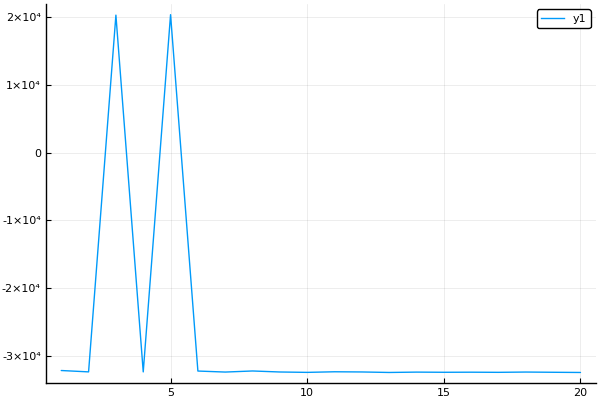

In [125]:
E_list = [E(ψ) for ψ in ψ_l]
pyplot()
plot(1:length(ψ_l), E_list)

# Using the measured series of states to produce structure function

In [10]:
# Given M number of tasks that should be done, we first calculate the available
# processes (np) that can do tasks, and then calculate the minimal number of tasks on
# each process (M_min) as well as the number of processes that need to do an
# extra task (nw) s.t. we get all M tasks done. Thus 
# M = M_min(np-nw) + (M_min+1)*nw = np*M_min + nw
function splitParallell{T<:Int}(M::T)
    # Splitting the problem into np sub-problems.
    np = nprocs()
    # Minimum amount of work pr. process
    M_min = Int(floor(M/np))
    # Number of workers doing +1 extra work
    nw = M%np
    
    return np, M_min, nw
end

splitParallell (generic function with 1 method)

In [49]:
N = 10000
A = rand(N)
N/effective_sample_size(A)

1.0103495003812106

In [51]:
?size

search: size sizeof sizehint! Csize_t resize! filesize Cssize_t serialize



```
size(A::AbstractArray, [dim...])
```

Returns a tuple containing the dimensions of `A`. Optionally you can specify the dimension(s) you want the length of, and get the length of that dimension, or a tuple of the lengths of dimensions you asked for.

```jldoctest
julia> A = ones(2,3,4);

julia> size(A, 2)
3

julia> size(A,3,2)
(4, 3)
```


In [55]:
L = 4
A = rand(L,L)
v = [A[i] for i = 1:length(A)]
reshape(v, size(A)...) == A

true

In [40]:
# Given 
function avgErr(A::Array{Array{Float64, 2},1})
    avg_A = mean(A)
    sm_A = zeros(avg_A)
    M = length(A)
    N = length(avg_A)
    for m = 1:M
        for i = 1:N
            sm_A[i] += A[m][i]^2
        end
    end
    sm_A = sm_A./M
    τ_matrix = [N/effective_sample_size([A[m][i] for m=1:M]) for i=1:N]
    τ_matrix = reshape(τ_matrix, size(avg_A)...)
    
    err_A = sqrt.((1+2.*τ_matrix).*abs.(sm_A - avg_A.^2)./(M-1))
    
    return avg_A, err_A
end

avgErr (generic function with 1 method)

In [41]:
N = 10000
L = 4
A = [rand(L,L) for i = 1:N]
avg_A, err_A = avgErr(A)
for i = 1:length(avg_A)
    println("$(avg_A[i])±$(err_A[i])")
end

0.4996355317447886±0.0029131362227162493
0.49942668583107763±0.002880012052821908
0.49798333495796276±0.0028815186238290657
0.5032118797158748±0.0028923344424256494
0.5019110627011267±0.0028749703627855227
0.49912450175022766±0.002886112613211927
0.49773141639947±0.0028884597223230685
0.5024840364416173±0.0028832337894945845
0.5053257122709898±0.0029028085836377755
0.49616441467337036±0.0029085608892154397
0.5028341383006175±0.0028657403944262663
0.5025481291438693±0.0029160452864170684
0.4999221061714541±0.002887513276588575
0.5018632929153328±0.0028873427778103823
0.5037237250897075±0.0028855155464017446
0.49486365919626024±0.0028872061099989043


In [71]:
typeof((1,1))

Tuple{Int64,Int64}

In [93]:
signif(12.102, 1)

10.0

In [81]:
ismatch(r"[e]", "$(signif(1.532e7,1))")

true

In [34]:
function scientificRounding{T<:Real}(val::T, err::T; extra_digits::Int64 = 0)
    if err < 0.0
        println("Warning: error less than zero inserted: $(err)")
        err = abs(err)
    end
    # First we find the number of decimals needed for the first significant digit of the error
    # Round to first significant digit
    err_temp = signif(err, 1)
    # Find the first significant digit
    st = "$(err_temp)"
    if ismatch(r"[e]", st)
        st = st[1]
    else
        st = reverse("$(err_temp)")
        st = match(r"[1-9]", st).match
    end
    sig = parse(Int64, st)
    # Now divide by this integer to get a number on the form 10^(-d) and extract d through log10
    digi_num = floor(Int64, -log10(err_temp/sig))
    # Finally use the number of digits to round the value (note that this number could be negative)
    val = round(val, digi_num+extra_digits)
    return val, signif(err, 1+extra_digits)
end

scientificRounding (generic function with 1 method)

In [127]:
scientificRounding(103.12435483, 1.1038572)

(103.0, 1.0)

In [124]:
err = 0.0015483
val = 4856.4919740
err = signif(err, 1)
str = reverse("$(err)")
str = match(r"[1-9]", str).match
man = parse(Int64, str)
digi = floor(Int64, -log10(err/man))
val = round(val, digi)

4856.492

In [14]:
function maxRelErr{T<:Real}(avg_A::Array{T,2}, err_A::Array{T,2})
    v = 1; h = 1
    val = err_A[1]/avg_A[1]
    for v_pos = 1:size(avg_A,1), h_pos = 1:size(avg_A,2)
        rel = err_A[v_pos,h_pos]/avg_A[v_pos,h_pos]
        if rel > val
            val = rel
            v = v_pos; h = h_pos
        end
    end
    return v, h, val
end

maxRelErr (generic function with 1 method)

In [74]:
function maxRelErrString{T<:Real}(avg_A::Array{T,2}, err_A::Array{T,2})
    v, h, rel_err = maxRelErr(avg_A, err_A)
    avg, err = scientificRounding(avg_A[v,h], err_A[v,h])
    return " rel_err = $(signif(rel_err,1))\t@ [$(v), $(h)] for\t $(avg)±$(err)"
end

maxRelErrString (generic function with 1 method)

In [142]:
N = 100000
L = 4
A = [rand(L,L) for i = 1:N]
avg_A, err_A = avgErr(A)
for i = 1:length(avg_A)
    av, err = scientificRounding(avg_A[i], err_A[i])
    println("$(av)±$(err)\t$(err_A[i]/avg_A[i])")
end
println(maxRelErrString(avg_A, err_A))

0.5±0.002	0.003164262632554962
0.5±0.002	0.0031642721977285086
0.5±0.002	0.0031602581888440073
0.498±0.002	0.0031743424776764944
0.499±0.002	0.0031685643523052366
0.501±0.002	0.003158305910078411
0.5±0.002	0.0031610054795734774
0.5±0.002	0.0031636648512816104
0.5±0.002	0.003165640184520126
0.5±0.002	0.0031642864289884516
0.5±0.002	0.003164665417214285
0.5±0.002	0.0031655343331058816
0.502±0.002	0.003148356785457976
0.5±0.002	0.0031617505444865726
0.499±0.002	0.0031659993440340956
0.501±0.002	0.0031581724939536223
0.498±0.002 @ [4, 1] =>	rel_err = 0.003


In [148]:
?sort!

search: sort! sortperm! sort sortrows sortperm sortcols Cshort issorted



```
sort!(v; alg::Algorithm=defalg(v), lt=isless, by=identity, rev::Bool=false, order::Ordering=Forward)
```

Sort the vector `v` in place. `QuickSort` is used by default for numeric arrays while `MergeSort` is used for other arrays. You can specify an algorithm to use via the `alg` keyword (see Sorting Algorithms for available algorithms). The `by` keyword lets you provide a function that will be applied to each element before comparison; the `lt` keyword allows providing a custom "less than" function; use `rev=true` to reverse the sorting order. These options are independent and can be used together in all possible combinations: if both `by` and `lt` are specified, the `lt` function is applied to the result of the `by` function; `rev=true` reverses whatever ordering specified via the `by` and `lt` keywords.

# Examples

```jldoctest
julia> v = [3, 1, 2]; sort!(v); v
3-element Array{Int64,1}:
 1
 2
 3

julia> v = [3, 1, 2]; sort!(v, rev = true); v
3-element Array{Int64,1}:
 3
 2
 1

julia> v = [(1, "c"), (3, "a"), (2, "b")]; sort!(v, by = x -> x[1]); v
3-element Array{Tuple{Int64,String},1}:
 (1, "c")
 (2, "b")
 (3, "a")

julia> v = [(1, "c"), (3, "a"), (2, "b")]; sort!(v, by = x -> x[2]); v
3-element Array{Tuple{Int64,String},1}:
 (3, "a")
 (2, "b")
 (1, "c")
```


In [16]:
function matrixIndices(i::Int64, L_v::Int64)
    if i%L_v == 0
        v = L_v
        h = floor(Int64, i/L_v)
    else
        h = floor(Int64, i/L_v)+1
        v = i-(h-1)*L_v
    end
    return v,h
end

matrixIndices (generic function with 1 method)

In [17]:
function findMaximaIndices{T<:Real}(A::Array{T, 2}; n::Int64=1)
    L_v = size(A,1)
    maxes = [[A[i], i] for i = 1:length(A)]
    sort!(maxes, rev=true, by = x -> x[1])
    return [[matrixIndices(Int(maxes[i][2]), L_v)...] for i = 1:n]
end
    

findMaximaIndices (generic function with 1 method)

In [174]:
L = 4
A = rand(L,L)
findMaximaIndices(A, n=2)

2-element Array{Array{Int64,1},1}:
 [2, 4]
 [1, 4]

In [175]:
A

4×4 Array{Float64,2}:
 0.60869    0.42165   0.516686  0.784817
 0.425431   0.411864  0.73956   0.998514
 0.484213   0.26408   0.214698  0.171939
 0.0267283  0.344671  0.465018  0.446066

In [164]:
L = 4
A = [[v,h] for v = 1:4, h = 1:4]
for i = 1:length(A)
    println("$(i)\t$(A[i])\t$(matrixIndices(i, size(A,1)))")
end

1	[1, 1]	(1, 1)
2	[2, 1]	(2, 1)
3	[3, 1]	(3, 1)
4	[4, 1]	(4, 1)
5	[1, 2]	(1, 2)
6	[2, 2]	(2, 2)
7	[3, 2]	(3, 2)
8	[4, 2]	(4, 2)
9	[1, 3]	(1, 3)
10	[2, 3]	(2, 3)
11	[3, 3]	(3, 3)
12	[4, 3]	(4, 3)
13	[1, 4]	(1, 4)
14	[2, 4]	(2, 4)
15	[3, 4]	(3, 4)
16	[4, 4]	(4, 4)


In [166]:
A[2,1]

2-element Array{Int64,1}:
 2
 1

In [69]:
# Takes in a list of states and measures the vorticity and structure function for each of them.
@everywhere function structureFunctionWork{T<:Real}(k_matrix::Array{Array{T,1},2}, ψ_list::Array{State,1}; visible=false)
    PROG_NUM = 10
    M = length(ψ_list)
    L_k1 = size(k_matrix, 1)
    L_k2 = size(k_matrix, 2)
    L = size(ψ_list[1].lattice, 1)
    
    #Setup measurement storage
    S⁺ = [zeros(L_k1, L_k2) for i = 1:M]; S⁻ = [zeros(L_k1, L_k2) for i = 1:M]
    V⁺ = [zeros(L,L) for i = 1:M]; V⁻ = [zeros(L,L) for i = 1:M]
    
    # Measure for each of the states in the list
    for m = 1:M
        V⁺_cube, V⁻_cube = vortexSnapshot(ψ_list[m])
        V⁺[m] = avgVort(V⁺_cube); V⁻[m] = avgVort(V⁻_cube)
        
        # We use the vortex snapshots to measure the structure function
        for v_pos = 1:L_k1, h_pos = 1:L_k2
            S⁺[m][v_pos,h_pos], S⁻[m][v_pos,h_pos] = structureFunction(k_matrix[v_pos,h_pos], ψ_list[m], V⁺[m], V⁻[m])
        end
    end     
    
    return S⁺, S⁻, V⁺, V⁻
end

In [65]:
# Normalizes the matrices found through 
# structureFunctionWork(::Array{Array{Float64,1},2}, ::Array{State,1}; ::Bool)
function normalizeSFVL!(S⁺, S⁻, V⁺, V⁻, syst)
    
    s_norm_inv = 1/(syst.L^2*syst.f*two_pi)^2
    v_norm_inv = 1/two_pi
    
    S⁺ = s_norm_inv.*S⁺; S⁻ = s_norm_inv.*S⁻;
    V⁺ = v_norm_inv.*V⁺; V⁻ = v_norm_inv.*V⁻;
    return S⁺, S⁻, V⁺, V⁻
end

normalizeSFVL! (generic function with 1 method)

In [78]:
function structureFunction{T<:Real}(filename::AbstractString, k_matrix::Array{Array{T, 1},2})
    
    # Get pre-measured states.
    ψ_list = loadStates(filename)
    
    syst = ψ_list[1].consts
    L = syst.L
    
    # Checking that the k matrix has equal dimensions
    L_k = size(k_matrix, 1)
    size(k_matrix, 2) == L_k || throw(error("k_matrix dimensions are not equal"))
    
    M = length(ψ_list)
    np, M_min, nw = splitParallell(M)
    
    # Setup storage.
    S⁺ = Array{Array{Float64, 2},1}(M); S⁻ = Array{Array{Float64, 2},1}(M)
    V⁺ = Array{Array{Float64, 2},1}(M); V⁻ = Array{Array{Float64, 2},1}(M)
    
    # Make sure that we have enough states
    length(ψ_list) >= np || throw(error("ERROR: Not enough states in list"))
    
    # Setup worker futures
    futures = [Future() for i=1:(np-1)]
    
    println("Starting $(M) measurements on $(np) processes doing max $(M_min + Int(ceil(nw/np))) measurements each
on a $(L)×$(L) system.")
    
    # Start +1 workers
    for i = 1:nw
        futures[i] = @spawn structureFunctionWork(k_matrix, ψ_list[(M_min+1)*(i-1) + 1:(M_min+1)*i])
        println("Starting states: $((M_min+1)*(i-1) + 1):$((M_min+1)*i)")
    end
    # Start remaining workers
    for i = 1:np-nw-1
        futures[nw+i] = @spawn structureFunctionWork(k_matrix,
            ψ_list[M_min*(i-1)+nw*(M_min+1)+1:M_min*(i-1)+nw*(M_min+1)+M_min])
        println("Starting states: $(M_min*(i-1)+nw*(M_min+1)+1):$(M_min*(i-1)+nw*(M_min+1)+M_min)")
    end
    # Make the master process work as well
    int = 1:M_min
    S⁺[int], S⁻[int], V⁺[int], V⁻[int] = structureFunctionWork(k_matrix,
        ψ_list[M_min*(np-nw-1-1)+nw*(M_min+1)+M_min+1:M_min*np+nw]; visible=true)
    println("Starting states: $(M_min*(np-nw-1-1)+nw*(M_min+1)+M_min+1):$(M_min*np+nw)")
    println("Saving to: $(1):$(M_min)")
    
    println("Measurements done, collecting parallell results.")
    # Collect results
    for i = 1:nw
        int = (i-1)*(M_min+1)+1+M_min:i*(M_min+1)+M_min
        S⁺[int], S⁻[int], V⁺[int], V⁻[int] = fetch(futures[i])
        println("Saving to: $((i-1)*(M_min+1)+1+M_min):$(i*(M_min+1)+M_min)")
    end
    for i = 1:np-nw-1
        int = (i-1)*M_min+nw*(M_min+1)+1+M_min:i*M_min+nw*(M_min+1)+M_min
        S⁺[int], S⁻[int], V⁺[int], V⁻[int] = fetch(futures[nw+i])
        println("Saving to: $((i-1)*M_min+nw*(M_min+1)+1+M_min):$(i*M_min+nw*(M_min+1)+M_min)")
    end
    
    println("Parallell measurements done. Processing.")
    
    # Normalize values
    S⁺, S⁻, V⁺, V⁻ = normalizeSFVL!(S⁺, S⁻, V⁺, V⁻, syst)
    
    # Calculate averages and errors.
    avg_S⁺, err_S⁺ = avgErr(S⁺); avg_S⁻, err_S⁻ = avgErr(S⁻)
    avg_V⁺, err_V⁺ = avgErr(V⁺); avg_V⁻, err_V⁻ = avgErr(V⁻)
    

    # Sum of all vorticities
    println("\nSum of vorticity of random snapshot:\nV⁺: \t$(sum(V⁺[rand(1:M)]))
V⁻: \t$(sum(V⁻[rand(1:M)]))")
    
    # Finding max relative error in the matrices.
    println("\nMax relative errors\nS⁺:\t$(maxRelErrString(avg_S⁺, err_S⁺))
S⁻:\t$(maxRelErrString(avg_S⁻, err_S⁻))\nV⁺:\t$(maxRelErrString(avg_V⁺, err_V⁺))
V⁻:\t$(maxRelErrString(avg_V⁻, err_V⁻))")
    
    # Finding max values over the matrices.
    N_MAX = 3
    max_S⁺= findMaximaIndices(avg_S⁺; n=N_MAX); max_S⁻ = findMaximaIndices(avg_S⁻; n=N_MAX)
    println("\nMaximum of S⁺")
    for i = 1:length(max_S⁺)
        avg, err = scientificRounding(avg_S⁺[max_S⁺[i]...], err_S⁺[max_S⁺[i]...])
        println("$(max_S⁺[i]):   \t$(avg) ± $(err)")
    end
    
    
    return avg_V⁺, err_V⁺, V⁺, avg_V⁻, err_V⁻, V⁻, avg_S⁺, err_S⁺, S⁺, avg_S⁻, err_S⁻, S⁻
end


structureFunction (generic function with 3 methods)

# Debugging EVERYTING!

In [20]:
include("../Source/functions_plots_and_files.jl")

makeDirRec (generic function with 1 method)

In [23]:
@time (t₀, ψ_ref, sim_ref, ψ_w, sim_w) = initializeParallelStatesS(syst, sim);

Thermalizing 3 states
Number of parallel workers: 2
Worker 1 initially thermalised after 19 steps
Worker 2 initially thermalised after 19 steps
All workers initially thermalized after 1001 steps
Checking average ∈ [1002, 1272]
Thermalization successful between T = [1002, 1272]
Worker 1: ΔE = 0.12753041343944974 ± 27.629260832902865
Worker 2: ΔE = 5.025943300825474 ± 22.891531678347942
Final thermalization time: 1392
  6.541502 seconds (14.73 M allocations: 833.006 MiB, 9.06% gc time)
Calculating energies and acceptance rates
Saving plots to files


In [24]:
@time measurementSeries!([ψ_ref, ψ_w...], sim_ref, M, Δt; filename="state_list.data")

Starting 300 measurements on 3 processes doing max 100 measurements each
on a 10×10 system, corresponding to 40000 MCS pr. process
Measurement progress: 10%
Measurement progress: 20%
Measurement progress: 30%
Measurement progress: 40%
Measurement progress: 50%
Measurement progress: 60%
Measurement progress: 70%
Measurement progress: 80%
Measurement progress: 90%
Measurement progress: 100%
Measurements done, collecting parallell results.
Parallell measurements done. Writing remaining measurements to disk.
Measurements saved to:
/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Notebooks/state_list.data


1

It seems that the parallel-processes doesn't start until the master process is done. This has to be looked into!

In [79]:
@time av_V⁺, err_V⁺, V⁺, av_V⁻, err_V⁻, V⁻, av_S⁺, err_S⁺, S⁺, av_S⁻, err_S⁻, S⁻ = structureFunction("state_list.data", k_matrix);

Starting 300 measurements on 3 processes doing max 100 measurements each
on a 10×10 system.
Starting states: 1:100
Starting states: 101:200
Starting states: 201:300
Saving to: 1:100
Measurements done, collecting parallell results.
Saving to: 101:200
Saving to: 201:300
Parallell measurements done. Processing.

Sum of vorticity of random snapshot:
V⁺: 	10.000000000000002
V⁻: 	10.0

Max relative errors
S⁺:	 rel_err = 0.2	@ [3, 1] for	 0.08±0.02
S⁻:	 rel_err = 0.1	@ [3, 6] for	 0.01±0.001
V⁺:	 rel_err = 0.3	@ [3, 5] for	 0.07±0.02
V⁻:	 rel_err = 0.2	@ [5, 6] for	 0.07±0.01

Maximum of S⁺
[5, 6]:   	1.0 ± 6.0e-9
[10, 1]:   	0.34 ± 0.03
 31.382458 seconds (33.49 M allocations: 1.026 GiB, 18.03% gc time)


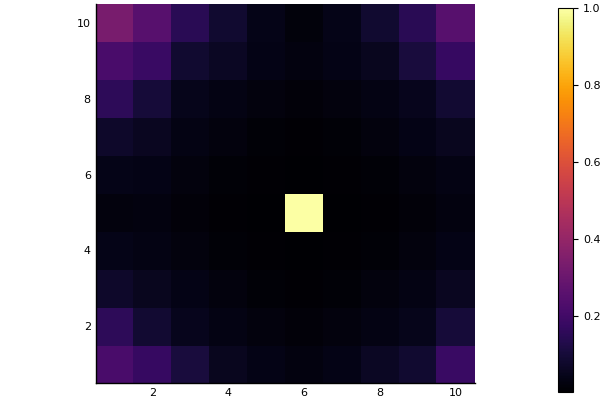

In [80]:
using Plots
pyplot()
heatmap(1:10, 1:10, av_S⁺, aspect_ratio=1)

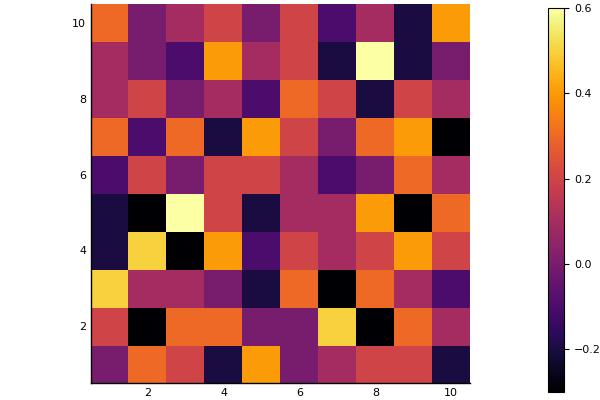

In [62]:
heatmap(1:10, 1:10, V⁺[1], aspect_ratio=1)

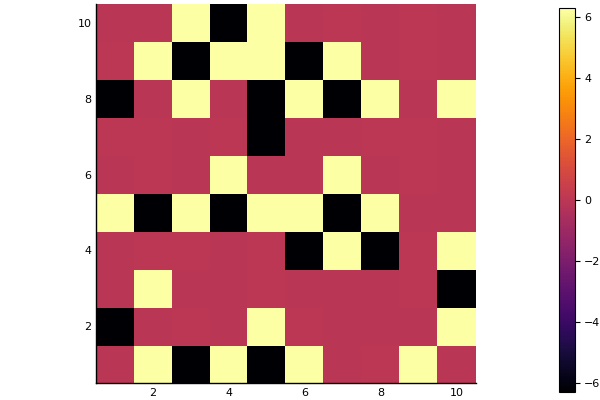

In [55]:
v1, v2 = vortexSnapshot(ψ_ref)
heatmap(1:10, 1:10, v1[:,:,1], aspect_ratio=1)